In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import json
from itertools import product

In [10]:
import sys
sys.path.append('..')

In [2]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label is not None:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [3]:
class Flatten:
    def __call__(self, img):
        return img.flatten()

# Data

In [4]:
N = 28
NUM_CLASSES = 10
SEED = 42

In [5]:
transforms = torchvision.transforms.Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Flatten(),
])

In [6]:
train_dataset = datasets.MNIST(root='../data', train=True, download=False, transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [7]:
test_dataset = datasets.MNIST(root='../data', train=False, download=False, transform=transforms)
# test_loader = DataLoader(Subset(test_dataset, np.arange(1_000)), batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
for img, label in test_loader:
    break

7


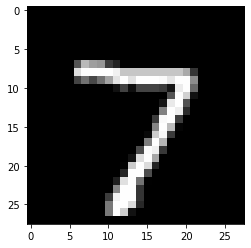

In [9]:
imshow(img[0].reshape(N, N), label=label[0].item())

# Activations

In [11]:
from src.activation import Tanh, Sigmoid, ReLU, Softmax

# Costs

In [13]:
from src.cost import MSE, CrossEntropy

# Optimizer

In [39]:
from src.optim import SGD, Adam 

# Net layers

In [43]:
from src.nn import Linear

In [42]:
class Linear():
    def __init__(self, n_in, n_out):
        self.w = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)
        self.b = np.zeros(n_out)
        self.requires_grad = True
    def forward(self, x):
        self.old_x = x
        return np.dot(x, self.w) + self.b

    def backward(self,grad):
        self.grad_b = grad.mean(axis=0)
        self.grad_w = self.old_x.T @ grad
        return np.dot(grad, self.w.T)

# Model 

In [40]:
class Model():
    def __init__(self, layers, cost, optimizer):
        self.layers = layers
        self.cost = cost
        self.optimizer = optimizer
        self.optimizer.init_params(self)
        
    def one_hot(self, label):
        return np.eye(10)[label]
    
    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x), y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
    
    def train(self, train_loader, test_loader, epochs, num_samples=10_000, verbose=True):
        samples = 0
        accs = []
        losses = []
        for epoch in tqdm(range(epochs)):
            self.cur_epoch = epoch
            for img, label in train_loader:
                bs = img.shape[0]
                y = self.one_hot(label)
                x = img.numpy()
                self.cur_x = x
                self.cur_y = y

                self.loss(x, y)
                self.backward()

                self.optimizer.step()
            
            acc, loss = self.validate(test_loader)
            if verbose:
                print(f"epoch: {epoch}")
                print(f"loss: {loss} acc: {acc}")
            accs.append(acc)
            losses.append(loss)
        return accs, losses
    
    def validate(self, loader):
        losses = []
        acc = 0
        counter = 0
        for img, label in loader:
            bs = img.shape[0]
            y = self.one_hot(label)
            x = img.numpy()
            
            preds = np.argmax(np.array(self.forward(x)), axis=1)
            labels = label.numpy()
            
            acc += sum(labels == preds)
            counter += bs
            
            losses.append(self.loss(x, y))
        return acc / counter, np.mean(losses)